# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [1]:
import numpy as np
import scipy
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import ipywidgets as widgets


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

# Model description

We consider a simple version of the **AS-AD model** where:

* $y_t$ is output in period t, $\bar{y}$ is natural output
* $g_t$ is government consumption in period t, $\bar{g}$ is equilibrium government consumption
* $r_t$ is the real interest rate in period t, $\bar{r}$ is the natural real interest rate
* $i_t$ is the nominal interest rate in period t
* $\pi_t$ is inflation in period t, $\pi^{e}_{t+1}$ is expected inflation in period t+1, $\pi^*$ is target inflation
* $z_t$ is a demand shock, initially assumed to be 0
* $s_t$ is a supply shock, initially assumed to be 0


The **goods market equilibrium** is stated as:

$$ y_t-\bar{y} = \alpha_1 (g_t-\bar{g}) -\alpha_2(r_t-\bar{r}) + v_t $$

The **Taylor rule** is stated as:

$$ i_t = \bar{r_t} + \pi^{e}_{t+1}+h(\pi_t-\pi^*)+b(y_t-\bar{y}) $$

and the **Fisher equation** is given by:

$$r_t=i_t-\pi^e_{t+1}$$

By defining $\hat{x_t}=x_t-\bar{x}$ for all variables and $\hat{\pi_t}=\pi_t-\pi^*$, the **AD curve** then becomes

$$ \hat{y_t} = -\alpha\hat{\pi_t}+z_t $$
$$ \hat{\pi_t} = -\frac{1}{\alpha}\hat{y_t}+\frac{1}{\alpha}z_t $$

where:

$$ \alpha \equiv \frac{\alpha_2h}{1+\alpha_2b}$$ and $$z_t\equiv \frac{\alpha_1\hat{g_t}+v_t}{1+\alpha_2b}$$


The **SRAS curve** with static expectations is described by:

$$\pi_t = \pi_{t-1}+\gamma\hat{y_t}+s_t$$

Subtracting the inflation target from both sides of the equation, we can write the SRAS curve as:

$$\hat{\pi_t} = \hat{\pi_{t-1}}+\gamma\hat{y_t}+s_t$$


# Model setup and symbolic solution
We begin by defining the symbols we will use:

In [2]:
y_hat = sm.symbols('y^hat_t')
pi_hat = sm.symbols('pi^hat_t')
pi_hat_last = sm.symbols('pi^hat_t-1')
gamma = sm.symbols('gamma')
s = sm.symbols('s_t')
alpha = sm.symbols('alpha')
z = sm.symbols('z_t')

Then we define the **AD-curve** and the **SRAS-curve**

In [3]:
AD = sm.Eq(pi_hat,(-1/alpha*y_hat+1/alpha*z))
SRAS = sm.Eq(pi_hat, (pi_hat_last+gamma*y_hat+s)) 
display(AD,SRAS)

Eq(pi^hat_t, -y^hat_t/alpha + z_t/alpha)

Eq(pi^hat_t, gamma*y^hat_t + pi^hat_t-1 + s_t)

and **solve** AS = AD for $\hat{\pi_t}$ and $\hat{y_t}$:

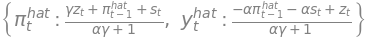

In [4]:
sm.init_printing()
sol = sm.solve([AD,SRAS],(y_hat,pi_hat))
sol

We turn the AD and the SRAS curves as well as the equilibrium into functions to use in the plot below:

In [5]:
#Redefining the AD and SRAS curves as functions
AD_func = sm.lambdify((alpha,y_hat,z), (z-y_hat)/(alpha))
SRAS_func = sm.lambdify((gamma,y_hat,pi_hat_last,s), gamma*y_hat+pi_hat_last+s)

#Defining the sympy-solution as functions for the equilibrium
pi_func = sm.lambdify((alpha,gamma,pi_hat_last,z,s),sol[pi_hat])
y_func =  sm.lambdify((alpha,gamma,pi_hat_last,z,s),sol[y_hat])

# Plotting the equilibrium

Now we set up a plot of the AS and AD curves (and the equilibrium values of $\hat{\pi_t}$ and $\hat{y_t}$):

In [6]:
def eq_plot(alpha_1=0.5,alpha_2=0.5,h=0.5,b=0.5,g_hat=0,v=0,gamma=0.5,pi_hat_last=0,s=0):
    """ function to plot AD curve, SRAS curve and equilibrium given parameters
    
    Args:
    
        alpha_1 (float): parameter, goods market sensitivity to  changes in government consumption. Assumed to be positive.
        alpha_2 (float): parameter, goods market sensitivity to  changes in the real interest rate. Assumed to be positive.
        h (float): parameter, monetary policy rule (inflation gap sensitivity). Assumed to be positive.
        b (float): parameter, monetary policy rule (output gap sensitivity). Assumed to be positive.
        g_hat (float): deviation in government consumption from the equilibrium
        v (float): demand shock
        gamma (float): parameter, slope of the SRAS curve. Assumed to be positive.
        pi_hat_last (float): inflation gap in last period 
        s (float): supply shock
    
    Returns:
        [y_star, pi_star] (coordinate): equilibrium output gap and inflation gap given parameters
    """

    # a. define parameters
    alpha = (alpha_2*h)/(1+alpha_2*b)
    z = (alpha_1*g_hat+v)/(1+alpha_2*b)
    
    # b. plot equilibrium point
    pi_star = pi_func(alpha,gamma,pi_hat_last,z,s)
    y_star = y_func(alpha,gamma,pi_hat_last,z,s)
    plt.plot(y_star,pi_star, marker='o', markersize=5, color="k")
    
    # c. plot AS and AD curves
    y_hat = np.arange(-10,10, 0.1)
    SRAS = SRAS_func(gamma,y_hat,pi_hat_last,s) 
    AD = AD_func(alpha,y_hat,z) 
    plt.plot(y_hat,SRAS)
    plt.plot(y_hat, AD)
    
    # d. set up plot
    plt.xlabel('$\hat{y}_t$')
    plt.ylabel('$\hat{\pi}_t$')
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    plt.legend(["equilibrium","SRAS","AD"])
    plt.show()
    return [y_star, pi_star]
    
widgets.interact(eq_plot, 
                alpha_1 = (0.001,1,0.01),
                alpha_2 = (0.001,1,0.01),
                h = (0.001,1,0.01),
                b = (0.001,1,0.01),
                v = (0.001,1,0.01),
                g_hat = (0.001,1,0.01),
                gamma = (0, 1,0.01),
                pi_hat_last = (-1,1,0.01),
                z = (-1,1,0.01),
                s = (-1,1,0.01))

interactive(children=(FloatSlider(value=0.5, description='alpha_1', max=1.0, min=0.001, step=0.01), FloatSlide…

<function __main__.eq_plot(alpha_1=0.5, alpha_2=0.5, h=0.5, b=0.5, g_hat=0, v=0, gamma=0.5, pi_hat_last=0, s=0)>

From the above plot we see how the AD curve, the SRAS curve and the equilibrium change when we change parameters values. As is apparent from the model setup: 

* $\alpha_1$ is the goods market sensitivity to  changes in government consumption
* $\alpha_2$ is the goods market sensitivity to  changes in the real interest rate
* $h$ and $b$ are parameters from the monetary policy rule, $h$ is sensitivity to inflation gap, $b$ is sensitivity to output gap
* $\hat{g}$ is the deviation in government consumption from the equilibrium
* $v$ is a demand shock
* $\gamma$ is the slope of the SRAS curve
* $\hat{\pi_{t-1}}$ is the inflation gap in last period
* $s$ is a supply shock

Changing the parameters thus result in the expected changes in the curves and resulting equilibrium. Bear in mind that the plot is for a single given period and that all changes in parameters (or lagged inflation) are shown holding all else constant. Therefore, imposing a supply shock (for example) and removing it again will *not* show the convergence to equilibrium after a temporary shock. To show this, we will simulate the model below.


# Simulation
Now we want to simulate the model to see how the output gap and inflation gap are affected by temporary shocks to the economy. We therefore set up the model with a set of parameters and impose a shock. We assume that shocks to supply and demand follow AR(1) processes:

$$v_t = \delta v_{t-1} + x_t$$
$$s_t = \omega s_{t-1} + c_t$$

where $x_t$ is an exogenous shock to demand and $c_t$ is an exogenous shock to supply. We assume that these shocks are white noise, such that:

$$x_t \sim N(0,\sigma^2_x)$$
$$c_t \sim N(0,\sigma^2_c)$$

We choose to impose a random shock to either demand or supply in period 1 and set all subsequent shocks to zero. This is in order to see the effect of a single shock.

We begin by specifying the parameters in the model:

In [7]:
# a. specify parameters
parameters = {'alpha_1':0.5,
             'alpha_2':0.5,
             'g_hat':0,
             'h':0.5,
             'b':0.5,
             'gamma':0.5,
             'delta':0.8,
             'omega':0.15,
             'sigma_x':3.5,
             'sigma_c':3.5}

# b. calculate the defined alpha-parameter from given parameters
parameters['alpha'] = (parameters['alpha_2']*parameters['h'])/(1+parameters['alpha_2']*parameters['b'])

We then define a function to simulate the model with stochastic shocks to supply or demand. By setting supply_shock=True or demand_shock=True, a stochastic shock is imposed in period 1 (by drawing a random number from the distribution of $x_t$ or $c_t$). The shock is removed for all subsequent periods, that is $x_t=c_t=0 \quad \forall t>1$. Thus, in the periods $t>1$, the remaining shocks in $v_t$ and $s_t$ is from their autoregressive nature, so the shocks die out naturally over time. As we have set $\delta=0.8$ and $\omega=0.15$, shocks to demand (to $v_t$) die out faster than shocks to supply (to $s_t$).

In [8]:
def simulate(parameters,T,supply_shock=False, demand_shock=True):
    """ set up and run simulation with shock(s) in period 1
    
    Args:
    
        parameters (dict): model parameters
        T (int): number of periods to simulate
    
    Returns:
        sim (dict): results of simulation, parameters in T simulated periods
    """
    # a. set seed
    np.random.seed(1234)

    # b. allocate memory
    sim = {'y': np.zeros(T),
          'pi': np.zeros(T),
          'v': np.zeros(T),
          's': np.zeros(T),
          'z': np.zeros(T),
          'x':np.zeros(T),
          'c':np.zeros(T)}

    # c. draw random shock in period 1
    if supply_shock == True:
        sim['c'][1] = np.random.normal(loc=0,scale=parameters['sigma_c'])
    else:
        pass
    
    if demand_shock == True:
        sim['x'][1] = np.random.normal(loc=0,scale=parameters['sigma_x'])
    else:
        pass
        
    for t in range(1,T):
        
        # i. impose shocks
        sim['v'][t] = parameters['delta']*sim['v'][t-1] + sim['x'][t]
        sim['s'][t] = parameters['omega']*sim['s'][t-1] + sim['c'][t]
        
        # ii. calculate z parameter from shocks
        sim['z'][t] = (parameters['alpha_1']*parameters['g_hat']+sim['v'][t])/(1+parameters['alpha_2']*parameters['b'])
        
        # iii. calculate output
        sim['y'][t] = y_func(parameters['alpha'],parameters['gamma'],sim['pi'][t-1],sim['z'][t],sim['s'][t])
        
        # iv. calculate inflation
        sim['pi'][t] = pi_func(parameters['alpha'],parameters['gamma'],sim['pi'][t-1],sim['z'][t],sim['s'][t])
    
    return sim

We run the model for 101 periods. The model starts in period 0 and in period 1 a supply shock is imposed. We plot the values of the output gap and the inflation gap in all the simulated periods below.

In [9]:
# Simulation
T=101
sim = simulate(parameters,T, supply_shock=False, demand_shock = True)

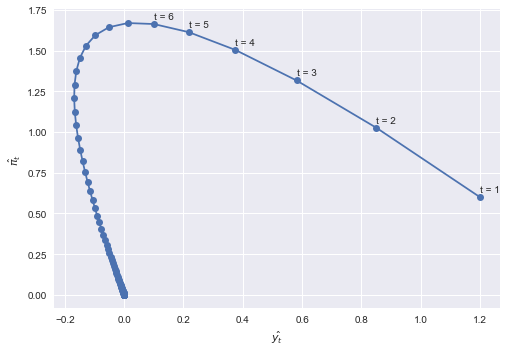

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(sim['y'][1:],sim['pi'][1:],ls='-',marker='o')
ax.set_xlabel('$\hat{y_t}$')
ax.set_ylabel('$\hat{\pi_t}$');
for i in range(1,7):
    ax.text(sim['y'][i],sim['pi'][i]+0.03,f't = {i}')

Now we create an interactive plot where we show how the AD and SRAS curves move as a result of either a demand shock or a supply shock (or both). 

In [11]:
def sim_plot(T=101, t=1, supply_shock=True, demand_shock=False):
    """ function to plot the simulation over time
    
    Args:
    
        T (int): number of periods to simulate
        t (int): period to plot
        supply_shock (bool): set to True to impose supply shock
        demand_shock (bool): set to True to impose demand shock
    
    Returns:
        sim['y'][t], sim['pi'][t] (coordinate): equilibrium output gap and inflation gap in period t
    """
    
    # a. run simulation
    sim = simulate(parameters,T, supply_shock, demand_shock)
    
    # b. set up figure
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,2,1)  #left panel, plots AD, SRAS and equilibrium point
    ax2 = fig.add_subplot(1,2,2) #right panel, plots time paths of output gap and equilibrium gap
    
    # i. LEFT PANEL
    # a. plot equilibrium point in period t
    ax.plot(sim['y'][t],sim['pi'][t],marker='o', color = 'k')

    # b. plot AS and AD curves
    y = np.arange(-10,10, 0.1)
    SRAS = SRAS_func(parameters['gamma'],y,sim['pi'][t-1],sim['s'][t])
    AD = AD_func(parameters['alpha'],y,sim['z'][t]) 
    ax.plot(y,SRAS)
    ax.plot(y, AD)
    
    # c. set labels and limits for left plot
    ax.set_xlabel('$\hat{y}_t$')
    ax.set_ylabel('$\hat{\pi}_t$')
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.legend(["equilibrium","SRAS","AD"])
    
    # ii. RIGHT PANEL
    # a. plot equilibrium points in period t
    ax2.plot(t-1,sim['y'][t], marker = 'o', color = 'C0', label = 'output gap in period t') 
    ax2.plot(t-1,sim['pi'][t], marker = 'o', color = 'C1', label = 'inflation gap in period t') 
    
    # b. plot time paths
    ax2.plot(np.arange(0,T-1),sim['y'][1:],label='$y_t$, output gap')
    ax2.plot(np.arange(0,T-1),sim['pi'][1:],label='$\pi_t$, inflation gap')
    
    # c. set legend and show plot
    ax2.legend()
    plt.show()
    
    return sim['y'][t], sim['pi'][t]
    
    
    
widgets.interact(sim_plot,
                T = (0,2*T),
                t = (0,T-1),
                supply_shock=False, 
                demand_shock=True
                )

interactive(children=(IntSlider(value=101, description='T', max=202), IntSlider(value=1, description='t'), Che…

<function __main__.sim_plot(T=101, t=1, supply_shock=True, demand_shock=False)>

# Numerical optimization 

We now turn to the central bank and assume that it wants to choose the parameters $b$ and $h$ to minimize a weighted sum of the inflation gap and the output gap over time. We change the simulation from before slightly in order to make it more realistic. We impose stochastic shocks to both supply and demand continuously, following the same AR(1), white noise processes as before. Before, we set new shocks to 0 after the initial shock at $t=1$, but now we continue imposing shocks in all time periods. Thus, we redefine the simulation function below.

I kunne lave et plot, hvor I simulere for forskellige værdier af b og h, viser varians af inflation og outputgab. Herefter kunne I bede en solver finde b og h så centralbankens objektive er så lille som muligt.

In [16]:
def simulate_cb(parameters,T, b, h):
    """ set up and run simulation with stochastic shocks in all time periods
    
    Args:
    
        parameters (dict): model parameters
        b (float): central bank parameter to be used (output gap sensitivity)
        h (float): central bank parameter to be used (inflation gap sensitivity)
        T (int): number of periods to simulate
    
    Returns:
        sim (dict): results of simulation, parameters in T simulated periods
    """
    # a. set seed
    np.random.seed(1234)

    # b. allocate memory and draw random shocks
    sim = {'y': np.zeros(T),
          'pi': np.zeros(T),
          'v': np.zeros(T),
          's': np.zeros(T),
          'z': np.zeros(T),
          'x': np.random.normal(loc=0,scale=parameters['sigma_x'], size=T),
          'c': np.random.normal(loc=0,scale=parameters['sigma_c'], size=T)}
    
    # c. calculate alpha parameter from b and h parameters
    alpha = (parameters['alpha_2']*h)/(1+parameters['alpha_2']*b)    
    
    #d. simulate
    for t in range(1,T):
        
        # i. impose shocks
        sim['v'][t] = parameters['delta']*sim['v'][t-1] + sim['x'][t]
        sim['s'][t] = parameters['omega']*sim['s'][t-1] + sim['c'][t]
        
        # ii. calculate z parameter from shocks
        sim['z'][t] = (parameters['alpha_1']*parameters['g_hat']+sim['v'][t])/(1+parameters['alpha_2']*b)
        
        # iii. calculate output
        sim['y'][t] = y_func(alpha,parameters['gamma'],sim['pi'][t-1],sim['z'][t],sim['s'][t])
        
        # iv. calculate inflation
        sim['pi'][t] = pi_func(alpha,parameters['gamma'],sim['pi'][t-1],sim['z'][t],sim['s'][t])
    
    return sim

We simulate the model for 1000 periods and plot the resulting output gap and inflation gap for various combinations of $h$ and $b$.

In [63]:
def sim_plot_cb(T,b=0.5,h=0.5):
    """ function to plot output gap and inflation gap over simulated periods
    
    Args:
        b (float): central bank parameter to be used (output gap sensitivity)
        h (float): central bank parameter to be used (inflation gap sensitivity)
        T (int): number of periods to simulate

Returns:
        sim['y'][t], sim['pi'][t] (coordinate): equilibrium output gap and inflation gap in period t
    """

    # a. simulation
    T=1000
    sim = simulate_cb(parameters,T,b,h)

    # b. figure
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('$t$')
    ax.plot(np.arange(T),sim['y'],label='$\hat{y}_t$, output gap')
    ax.plot(np.arange(T),sim['pi'],label='$\hat{\pi}_t$, inflation gap')
    ax.legend();

    # c. print
    def print_sim(sim):

        print(f'std. of output gap: {np.std(sim["y"]):.4f}')
        print(f'var. of output gap: {np.var(sim["y"]):.4f}')
        print(f'std. of inflation gap: {np.std(sim["pi"]):.4f}')
        print(f'var. of inflation gap: {np.var(sim["pi"]):.4f}')
            
    return print_sim(sim)
    
widgets.interact(sim_plot_cb,
                T = T,
                b = (0,1,0.01),
                h = (0,1,0.01),
                )

interactive(children=(IntSlider(value=1000, description='T', max=3000, min=-1000), FloatSlider(value=0.5, desc…

<function __main__.sim_plot_cb(T, b=0.5, h=0.5)>

Next, we select an optimizer to minimize a weighted sum of the standard deviation of inflation gap and the standard deviation of the output gap. 

In [60]:
def objective(guess):#, parameters, T):
    b = guess[0] 
    h = guess[1] 
    
    sim = simulate_cb(parameters, T, b, h)
    obj = w_y*np.var(sim["y"]) + w_pi*np.var(sim["pi"])
    
    return obj

# a. initial weights, guess and bounds
w_y = 0.5
w_pi = 0.5
guess = [0.5,0.5]
bounds = ((0,100),(0,100))

# b. call solver
result = optimize.minimize(objective, guess, method='SLSQP',bounds=bounds)

print(f'result: b = {result.x[0]:.3f} and h = {result.x[1]:.3f}')

result: b = 25.164 and h = 37.149


# Conclusion

ADD CONCISE CONCLUSION.